# Make Decision on Pricing

## Introduction:
XYZ company performed A/B test on product pricing, and wanted to know whether increase the price from 39 to 59 will also increase the revenue.

The control group sees the price of 39, and the test group sees the price of 59. Our common sense tells us that increasing the price will decrease the conversion rate, but the question is whether the decrease in conversion rate will be offset by a 50% increase in the price. 

In [1]:
# python 2.7
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import stats
import math

In [2]:
test_results = pd.read_csv('/Users/Wei.Zhao/Documents/2017_INSIGHT/Interview code prepare/Pricing_Test/test_results.csv')
user_table = pd.read_csv('/Users/Wei.Zhao/Documents/2017_INSIGHT/Interview code prepare/Pricing_Test/user_table.csv')

In [3]:
test_results.sample(3)

,user_id,timestamp,source,device,operative_system,test,price,converted
31788,119156,2015-03-27 17:60:22,ads-google,web,windows,1,59,0
11499,608511,2015-04-17 01:52:17,ads-bing,mobile,android,1,59,0
124467,685172,2015-04-01 11:06:15,ads-google,web,windows,0,39,0


In [4]:
user_table.sample(3)

,user_id,city,country,lat,long
50781,923626,San Buenaventura,USA,34.27,-119.26
133814,325265,Gilbert,USA,33.33,-111.76
147460,898434,New York,USA,40.67,-73.94


## Data Cleaning

* Users were randomly assigned to control group or test group, indicated by test column, where '0' stands for control and '1' stands for test. The control group saw price 39 and the test group was exposed to price 59. However, for some entries, the price was 39 but was also labeled as test, and vise versa. So I decide to drop these data entries.

In [5]:
# drop timestamp errors
test_results['timestamp']=pd.to_datetime(test_results['timestamp'] ,errors='coerce')
test_results.dropna(subset=['timestamp'],axis=0,inplace=True)

In [6]:
# split the data frame into control and test groups, store in two dataframes control_df, test_df, and combine the 
# two dataframe into test_results_cleaned
def split_control_test(df):
    df1 = df[df['price']==39].copy()
    df2 = df[df['price']==59].copy()
    return df1, df2
    
control_df,test_df = split_control_test(test_results)
control_df = control_df[control_df['test']==0]
test_df = test_df[test_df['test']==1]
test_results_cleaned = pd.concat([control_df,test_df])

## Validation of Random Assignment
  The prerequest for A/B test is the random sampling. So here I am going to check whether the users were randomly assigned to groups.

### Spatial distribution

In [7]:
user_table = user_table.merge(test_results_cleaned[['user_id','test']], how='inner', on='user_id')

(20, 55)

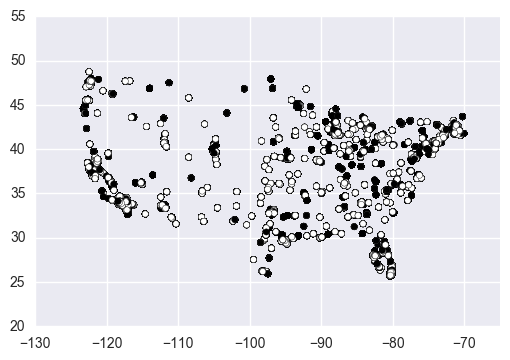

In [8]:
plt.scatter(user_table['long'],user_table['lat'],c=user_table['test'])
plt.xlim([-130,-65])
plt.ylim([20,55])

Inspired by fellows at Insight Data Science, to visualize the spatial distribution, we could plot longitude and latitude. It looks like groups are evenly distributed.

#### Next we'll look at ratio for each subcategories to see whether the users in the test groups are sampled proportional to the control group.

In [9]:
def combine_counts(df1,df2,col): 
    '''input control df and test df, count the users in each subcategories, and return the joined dataframe'''
    df1 = df1[['user_id',col]].groupby(col,as_index=False).count()
    df1.rename(columns={'user_id':'control_count'},inplace = True)
    df2 = df2[['user_id',col]].groupby(col,as_index=False).count()
    df2.rename(columns={'user_id':'test_count'},inplace = True)
    combined_df = df1.merge(df2,on = col)
    return combined_df
    
def ratio_cal(df):
    '''calculate the ratio for control and test df respectively'''
    control_size  = df['control_count'].sum()
    test_size = df['test_count'].sum()
    df.loc[:,'control_ratio'] = df.loc[:,'control_count'].apply(lambda x: x/float(control_size))
    df.loc[:,'test_ratio'] = df.loc[:,'test_count'].apply(lambda x: x/float(test_size))
    return df

def plot_ratio_compare(df,col):
    '''plot ratio'''
    ax = df[[col,'control_ratio','test_ratio']].plot.barh(title = col)
    ax.set_yticklabels(df[col]) 

In [10]:
# Specifically, whether users are sampled the same proportional as users in the control group across source, device and 
# operative system.
def ratio_compare (control_df,test_df):
    columns = ['source','device','operative_system']
    control_size = control_df.count()[0]
    test_size = test_df.count()[0]
    p_chi = {}
    for col in columns:
        combined_df = combine_counts(control_df,test_df,col)
        ratio_df = ratio_cal(combined_df)
        plot_ratio_compare(ratio_df,col) 

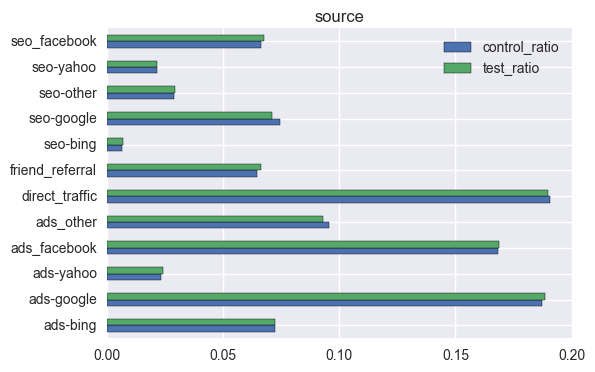

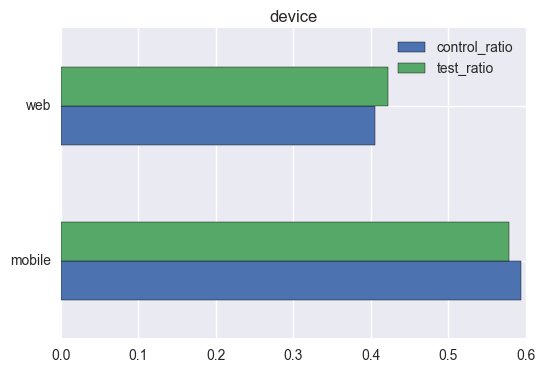

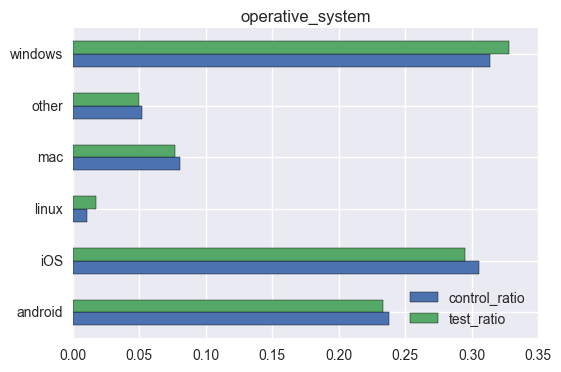

In [11]:
ratio_compare(control_df,test_df)

It looks like the users proportions are similar in control group and test group. So the sampling requirement for A/B test is satisfied.

## Basic analysis

* For this A/B test, company XYZ is trying to optimize the revenue, not the click through rate. Therefore, we need to look at revenue per visitor (RPV), which is the price multiplied by the conversion rate.

## Visualization by groups  
Here I dive deeper into the data, and look at each subgroup. Like people who visit the site through mobile app or through browser.            

In [12]:
import math

In [13]:
class group_RPV():
    ''' feature_col: the feature to split. 
        target_col: converted. 
    '''
    def __init__(self, df1, df2, feature_col=None, price_col ='price', target_col ='converted'):
        '''initialize with control_df, test_df, and feature_col (i.e. 'device,). If there is no input
           for feature_col, the default operation is over the entire dataframe
        '''
        self.df1 = df1
        self.df2 = df2
        self.price = price_col
        self.feature_col = feature_col
        self.target_col = target_col
        self.combine_control_test()
        self.expected_rpv_increase()
        self.AB_test_summary()  
        
    def conversion_rate_cal(self,df): 
        '''if specify the feature col, then operate on groupby object'''
        if self.feature_col:  
            # groupby, calculate total counts of visitors and mean conversion rate respectively, then join two tables
            _df = df[[self.feature_col,self.target_col]].groupby(self.feature_col,as_index=False).count()
            _df.rename(columns = {self.target_col:'count'},inplace=True)
            rpv_df = df[[self.feature_col,self.price,self.target_col]].groupby(self.feature_col,as_index=False).mean()
            rpv_df = rpv_df.merge(_df,on=self.feature_col)
            
        
        #if not specify the feature col, then operate on entire sample set
        # counts and mean covert are numpy numbers because they summarize over the entire dataframe
        else:
            
            counts = df[self.target_col].count()
            mean_convert = df[[self.price,self.target_col]].mean()
           
            rpv_df = pd.DataFrame({
                                   'converted':[mean_convert['converted']],
                                   'count':[counts],
                                   'price':[mean_convert['price']]})
         
        # calculate revenue per visitor: price * conversion rate
        rpv_df.loc[:,'rpv'] = rpv_df[self.price]*rpv_df[self.target_col]
        
        # Depends on control group or test group, rename the columns respectively for later join
        if rpv_df.loc[0,self.price] == 39.0:
            prefix = 'control_'
        else:
            prefix = 'test_'
        col_dict={}
        
        # don't rename the feature_col, reserved as key for joining
        for col in rpv_df.columns:
            if col!= self.feature_col:
                col_dict[col]=prefix+col
        rpv_df.rename(columns = col_dict,inplace=True)
        return rpv_df
    
    def combine_control_test(self): 
        '''calculate the expection value for revenue per visit, and calculate the difference between 
        control and test group'''   
        self.rpv_df_1 = self.conversion_rate_cal(self.df1)
        self.rpv_df_2 = self.conversion_rate_cal(self.df2)
        # join two tables on self.feature_col
        if self.feature_col:
            self.rpv_summary_df = self.rpv_df_1.merge(self.rpv_df_2,on=self.feature_col)
        # join two tables on index, and define the feature_col as 'overall'
        else:
            self.rpv_summary_df = self.rpv_df_1.join(self.rpv_df_2)
            self.feature_col ='over_all'
            self.rpv_summary_df[self.feature_col]='all'        
        return self
    
    def expected_rpv_increase(self):
        # calculate the expected rpv increase
        self.rpv_summary_df.loc[:,'rpv_increase']  \
        = self.rpv_summary_df['test_'+self.price]*self.rpv_summary_df['test_'+self.target_col]\
                       -self.rpv_summary_df['control_'+self.price]*self.rpv_summary_df['control_'+self.target_col]   
        return self.rpv_summary_df
     
    @staticmethod    
    def standard_error(cost_1,p1,n1,cost_2,p2,n2):
        var = (cost_1**2)*p1*(1-p1)/float(n1) + cost_2**2*p2*(1-p2)/float(n2)
        SE = math.sqrt(var)
        return SE*2 # account for 95% CI
    
    @staticmethod 
    def error_bar(row):
        r = row.values
        return group_RPV.standard_error(*r)
        
    def AB_test_summary(self):
        '''calculate the standard error'''
        columns = ['control_'+self.price,'control_'+self.target_col, 'control_count',
                   'test_'+self.price,'test_'+self.target_col, 'test_count']
        self.rpv_summary_df['error'] = self.rpv_summary_df.loc[:,columns].apply(lambda x : group_RPV.error_bar(x),axis=1)
        return self.rpv_summary_df[[self.feature_col,'rpv_increase','error']]
    
    def plot_stats(self):
        self.summary_df = self.AB_test_summary()
        ax =self.summary_df['rpv_increase'].plot.barh(xerr=self.summary_df['error'],title = self.feature_col)
        ax.set_xlabel('Expected Revenue Increase Per Visitor')
        ax.set_yticklabels(self.summary_df[self.feature_col]) 
        return self.summary_df
        
        

### Before breaking down to subgroups, let's look at the overall test results across all the platforms

,over_all,rpv_increase,error
0,all,0.140038,0.050371


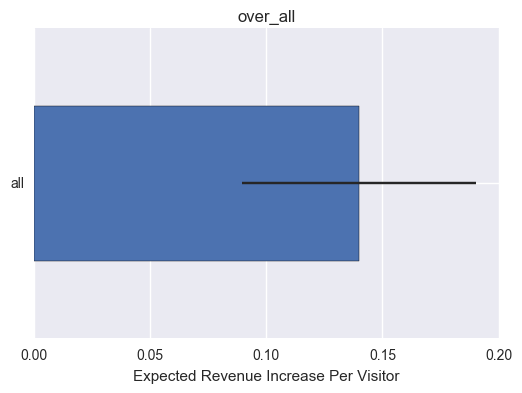

In [14]:
overall = group_RPV(control_df, test_df)
overall.plot_stats()

In [15]:
mean = overall.summary_df['rpv_increase']
SE = overall.summary_df['error']

In [16]:
print "The expected revenue increase per visitor is %.2f, and 95%% confidence interval is %.2f and %.2f."\
 %(mean, mean-SE, mean+SE)

The expected revenue increase per visitor is 0.14, and 95% confidence interval is 0.09 and 0.19.


* The expected revenue increase per visitor is 0.14, and 95% confidence interval is 0.09 and 0.19. The price A/B test is successful.

### Next let's look at the users visited the site using difference devices.

,device,rpv_increase,error
0,mobile,0.171891,0.066928
1,web,0.096496,0.076470


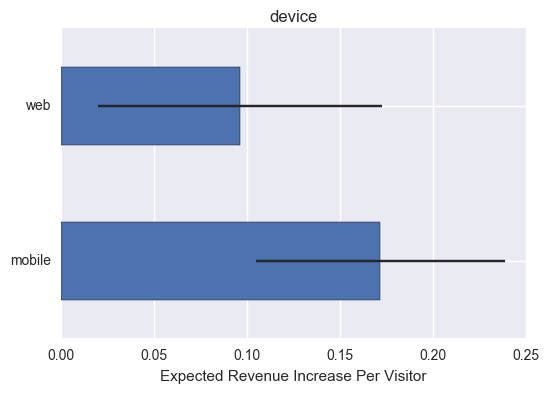

In [17]:
device = group_RPV(control_df, test_df,feature_col='device')
device.plot_stats()

### Users visited the site using different operative system

,operative_system,rpv_increase,error
0,android,0.096413,0.093245
1,iOS,0.244300,0.103471
2,linux,-0.629032,0.214009
3,mac,0.250393,0.208482
4,other,0.106057,0.188414
5,windows,0.106156,0.084617


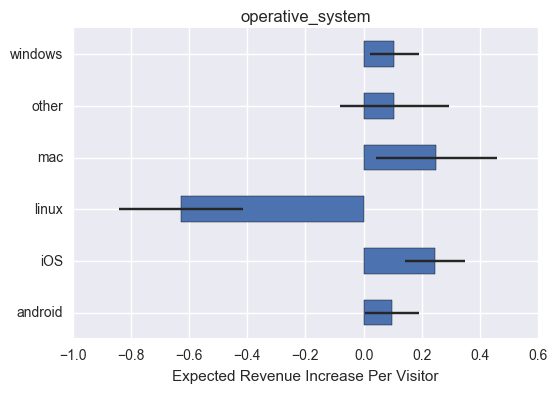

In [18]:
os = group_RPV(control_df, test_df,feature_col='operative_system')
os.plot_stats()

* For most platform, we gained enough evidence that setting the price at 59 will increase the revenue per visitor.  In the graph above, however, the users using linux system do not welcome the increase in price.

,source,rpv_increase,error
0,ads-bing,0.072561,0.150616
1,ads-google,0.270513,0.128333
2,ads-yahoo,-0.033132,0.275962
3,ads_facebook,0.063180,0.128973
4,ads_other,0.108756,0.144985
5,direct_traffic,0.079226,0.094181
6,friend_referral,0.356500,0.284761
7,seo-bing,-0.343942,0.614949
8,seo-google,0.250284,0.187466
9,seo-other,0.062496,0.270133


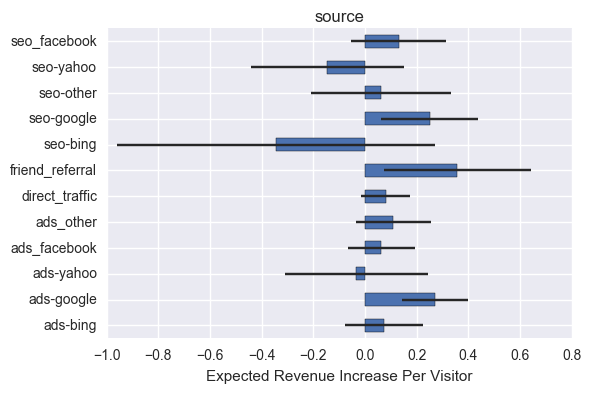

In [19]:
source = group_RPV(control_df, test_df,feature_col='source')
source.plot_stats()

* In the graph above, we break down users into smaller groups, therefore we have less confidence in the result. 

#### Considering the market share of the platforms, the mobile group, ios group, ads in google, sea-google and friend_referral, exhibit strong growth in revenue.

## Whether the A/B Test should be stopped

In [20]:
from datetime import datetime
import numpy as np

In [21]:
test_results_cleaned.sort_values('timestamp',inplace=True)

In [22]:
points = test_results_cleaned.count()
obs_times = np.linspace(3000, 300000,100).tolist()
obs_times = [int(x) for x in obs_times]

In [23]:
def time_evolution(df,obs_time):
    mean_list = np.zeros(len(obs_time))
    err_list = np.zeros(len(obs_time))
    for i,obs in enumerate(obs_time):
        df1,df2 = split_control_test(df.iloc[0:obs])
        overall = group_RPV(df1,df2)
        mn = overall.rpv_summary_df['rpv_increase'][0]
        err = overall.rpv_summary_df['error'][0]
        mean_list[i] = mn
        err_list[i] = err 
    return mean_list,err_list

In [24]:
mean_list, err_list = time_evolution(test_results_cleaned,obs_times)

In [25]:
exp_length_df = test_results_cleaned.iloc[obs_times].copy()
exp_length_df['rpv_increase'] = mean_list
exp_length_df['error']=err_list

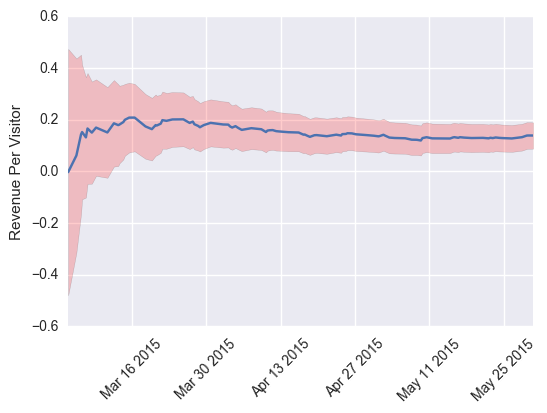

In [26]:
plt.plot(exp_length_df['timestamp'].values,exp_length_df['rpv_increase'])

plt.fill_between(exp_length_df['timestamp'].values,
                 mean_list - err_list,
                 mean_list + err_list,
                 facecolor='red', alpha=0.2)
plt.xticks(rotation=45)
plt.ylabel('Revenue Per Visitor')


The revenue per visitor shown in blue and confidence interval shaded in red converge as the length of experiment increase.

 ## Summary

Even though the conversion rate definitely drops as price increases from 39 to 59. However, the overall gain, calculated as 
conversion rate multiplied by price, increases for most of the platforms, in particular for mobile users, ios users, through google ads and friends-referral.
Some platforms like Linux and sea-bing and sea-yahoo under performed than others. Engineers should look into these platforms to improve user experience.

We are confident that the price test is successful, the experiment can stop because both p value and revenue gain per visitor stabilized. However, if we are interested in spefific sources where users come to the site, it is recommended to run the test for longer time. 